# Lab 4 Toering 11302925


* It is expected that you work individually and the usual plagarism rules apply.
* Submissions are to be made on canvas. Make sure that you add your student ID in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name].ipynb", for example "Lab2_Bongers.ipynb". 
* Please make sure your code will run without problems

_You need to fill in everywhere that there is a_ '__TODO__'

Feel free ask any questions during the computer lab sessions, or email the TA.

**The due date for the labs is next Wednesday at 14:59**

## Part 1

In this part of the lab you are going to fit the parameters of a Gaussian in two ways
- Method 1: Gradient descent on the averaged negative log likelihood
- Method 2: Moment matching

**You do not need to fill in a lot of code, but make sure you read everything and understand what is going on**

In [17]:
import matplotlib
import numpy as np

from matplotlib import pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

Here we generate the data from a Gaussian with random mean and variance.

Text(0.5,0,'x')

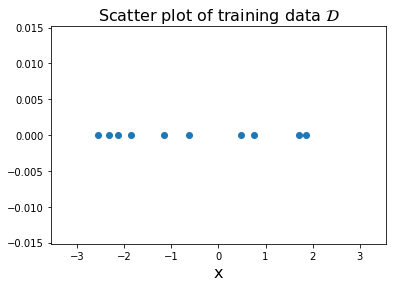

In [18]:
N = 10
mean_true = np.random.randn()
var_true = 1 + np.random.rand()
data = mean_true + np.sqrt(var_true)*np.random.randn(N)

# Plotting
datamin = np.amin(data)
datamax = np.amax(data)
absmax = np.maximum(np.abs(datamin), np.abs(datamax)) + 1
plt.figure(0)
plt.scatter(data, np.zeros(data.shape))
plt.xlim(-absmax, absmax)
plt.title('Scatter plot of training data $\mathcal{D}$', fontsize=16)
plt.xlabel('x', fontsize=16)

**TODO** Write a function which returns the averaged negative log-likelihood (denoted $\mathcal{L}$) of the parameters $\mu$ and $\sigma$ of a 1D Gaussian given $N$ data points i.e. $$\texttt{NLL}(\{x_i\}, \texttt{mu}, \texttt{sigma}) = \mathcal{L}(\mu,\sigma) = -\frac{1}{N} \sum_{i=1}^N \log \left ( \frac{1}{\sigma \sqrt{2\pi}} \exp \left \{ \frac{-(x_i - \mu)^2}{2\sigma^2} \right \} \right ).$$
**`for` loops are not allowed!**

Hint: You should rewrite the log of the Gaussian as in the lectures i.e. expand the log of a product etc.

In [19]:
def nll(data, mu, sigma):
    a = -(np.log(sigma+0.0001))-(0.5*np.log(2*np.pi+0.0001))-(0.5*((np.power(data-mu,2))/(np.power(sigma,2))))
    return -np.mean(a)

# Test
nll(np.array([1, 2, 3, 4, 5]), 1, 2)

2.3621436701984893

Here we show a plot of the NLL as a function of varying $\mu$ and $\sigma$ given the generated data

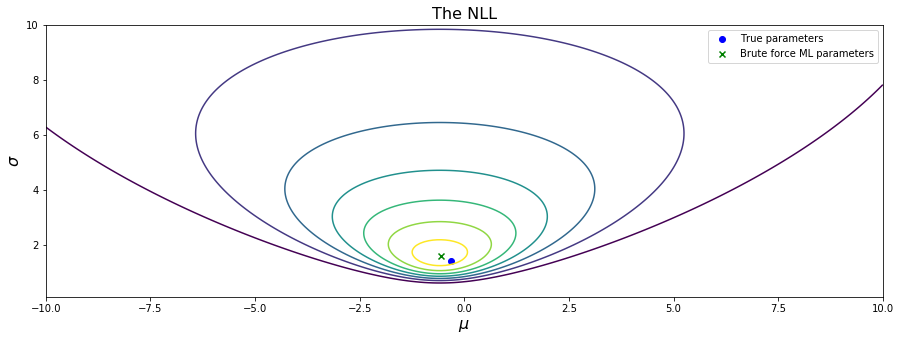

In [20]:
# Domain of the parameters space
muspace = np.linspace(-10, 10, num=200)
sigmaspace = np.linspace(0.1, 10, num=200)

# Compute the value of the nll at each parameter value: note this is an inefficient method
nlls = []
for m in muspace:
    for s in sigmaspace:
        nlls.append(nll(data, m, s))
nlls = np.asarray(nlls).reshape(200,200)

NLL_min = np.amin(nlls)
ind = np.unravel_index(np.argmin(nlls, axis=None), nlls.shape)
mean_brute = muspace[ind[0]]
std_brute = sigmaspace[ind[1]]

plt.figure(1, figsize=(15,5))
X, Y = np.meshgrid(muspace, sigmaspace)
plt.contour(X,Y,np.exp(-nlls.T))

# Plot the true parameters with a blue circle
plt.scatter(mean_true, np.sqrt(var_true), color='b', marker='o')

# Plot the brute force ML parameters with a green cross
plt.scatter(mean_brute, std_brute, color='g', marker='x')

plt.xlabel('$\mu$', fontsize=16)
plt.ylabel('$\sigma$', fontsize=16)
plt.title('The NLL', fontsize=16)
plt.legend(['True parameters', 'Brute force ML parameters'])

### Method 1
Now we are going to compute the maximum likelihood (ML) mean and variance through gradient descent on the averaged negative log-likelihood of the parameters given the data. At iteration $t$ you will update the parameters $\mu_t$ or $\sigma_t$ (jointly referred to as $\theta_t$) according to the equation

$$\theta_{t+1} \gets \theta_t - \lambda \left . \frac{\partial \mathcal{L}}{\partial \theta} \right |_{\theta=\theta_t}$$

At iteration $t$ we denote the loss $\mathcal{L}_t = \mathcal{L}(\mu_t, \sigma_t)$. The optimal loss is $\mathcal{L}^* = \mathcal{L}(\mu^*, \sigma^*)$.

**`for` loops are not allowed!**

**TODO** Accustom yourself with the code below, then fill in the missing parts. You need to fill in:
- `dLdmu(x, mu, sigma)`: takes in an array `X` of $N$ data points $\{x_i\}$, a scalar mean `mu`, and a scalar `sigma`. It should return a scalar for the gradient of the averaged negative log-likelihood wrt the mean i.e. $$\texttt{dLdmu(X,mu,sigma)} = -\frac{\partial}{\partial \mu} \left ( \mathcal{L}(\mu,\sigma) \right)$$
- `dLdsigma(x, mu, sigma)`: takes in an array `X` of $N$ data points $\{x_i\}$, a scalar mean `mu`, and a scalar `sigma`. It should return a scalar for the gradient of the averaged negative log-likelihood wrt the standard deviation i.e. $$\texttt{dLdsigma(X,mu,sigma)} = -\frac{\partial}{\partial \sigma} \left ( \mathcal{L}(\mu,\sigma) \right)$$
- `update_parameter(learning_rate, current_parameter, update)`: takes in a `learning_rate`, the current parameter `mu` or `sigma` and an `update` and updates according to the gradient descent rule.

In [21]:
def dLdmu(X, mu, sigma):
    return np.mean((-(X-mu)))/((np.power(sigma,2)))

def dLdsigma(X, mu, sigma):
    return np.mean((1/sigma)-((np.power((X-mu),2))/(np.power(sigma,3))))

def update_parameter(learning_rate, current_parameter, update):
    return (current_parameter - (learning_rate*update))

Final NLL: 1.8866892114225888


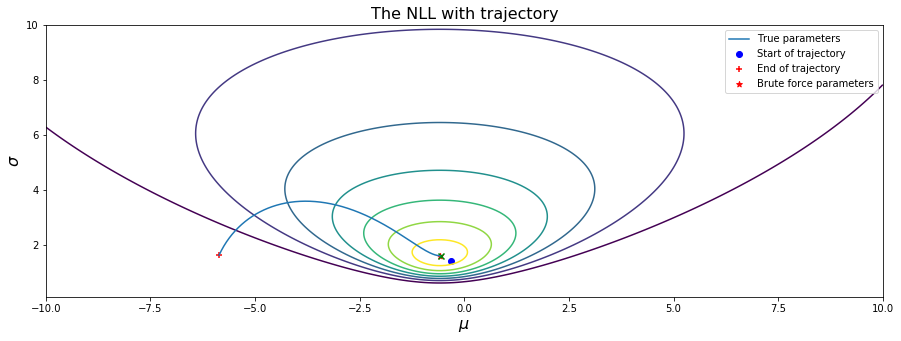

In [22]:
# Randomly initialize the mean and variance
mu0 = 20*(np.random.rand()-0.5)
sigma0 = 10*np.random.rand()
mu = mu0
sigma = sigma0

# These lists will store the trajectories of the parameters and loss
mus = [mu,]
sigmas = [sigma,]
losses = []

# Optimization meta-parameters
n_iter = 10000
learning_rate = 1e-2

# The optimization loop
for t in range(n_iter):
    loss = nll(data, mu, sigma)
    mu_new = update_parameter(learning_rate, mu, dLdmu(data, mu, sigma))
    sigma_new = update_parameter(learning_rate, sigma, dLdsigma(data, mu, sigma))
    
    mu = mu_new
    sigma = sigma_new
    
    # Store the trajectories
    mus.append(mu)
    sigmas.append(sigma)
    losses.append(loss)

# Convert lists to numpy arrays
mus = np.asarray(mus)
sigmas = np.asarray(sigmas)
losses = np.asarray(losses)

# Output of gradient descent
final_nll = losses[-1]
muend = mus[-1]
sigmaend = sigmas[-1]
print("Final NLL: {}".format(final_nll))

###############################################################
# Plotting
plt.figure(2, figsize=(15,5))
# Left figure: trajectory of the ML mean and std over time
plt.contour(X,Y,np.exp(-nlls.T))

# Plot true parameters and ML parameters
plt.scatter(mean_true, np.sqrt(var_true), color='b', marker='o')

# Plot trajectory ends
plt.scatter(mu0, sigma0, color='r', marker='+')
plt.scatter(muend, sigmaend, color='r', marker='*')

# Plot trajectory
plt.plot(mus, sigmas)
plt.scatter(mean_brute, std_brute, color='g', marker='x')

# Labelling
plt.xlabel('$\mu$', fontsize=16)
plt.ylabel('$\sigma$', fontsize=16)
plt.title('The NLL with trajectory', fontsize=16)
plt.legend(['True parameters', 'Start of trajectory', 'End of trajectory', 'Brute force parameters'])

Play about with the learning rate and the number of iterations. 
1) If the learning rate is too high or too small what happens? 
#### If the learning rate is too high the algorithm will take too big steps which can result in not reaching our minimum. If the learning rate is too small this simply results in a lot of calculation which takes more time
2) If the number of iterations is too high or too small, what happens
#### If the number of iterations is too small the gradient descent algorithm will not reach a minimum. If the number of iterations is too high it will simply take a lot of time

### Answer: If the learning rate is too high the plot will not appear.  If the learning rate is too small the parameters are not learned.

### Method 2
Now we are going to compute the maximum likelihood mean and variance through moment matching. We can use this method to verify that the solution our gradient descent optimizer has converged to is correct

**TODO** Fill in the expressions for `muML` and `sigmaML`

In [23]:
muML = np.mean(data)

sigmaML = np.sqrt(np.mean((np.power(data-muML,2))))


True parameters vs. brute force parameters distance: 0.03310075450698999


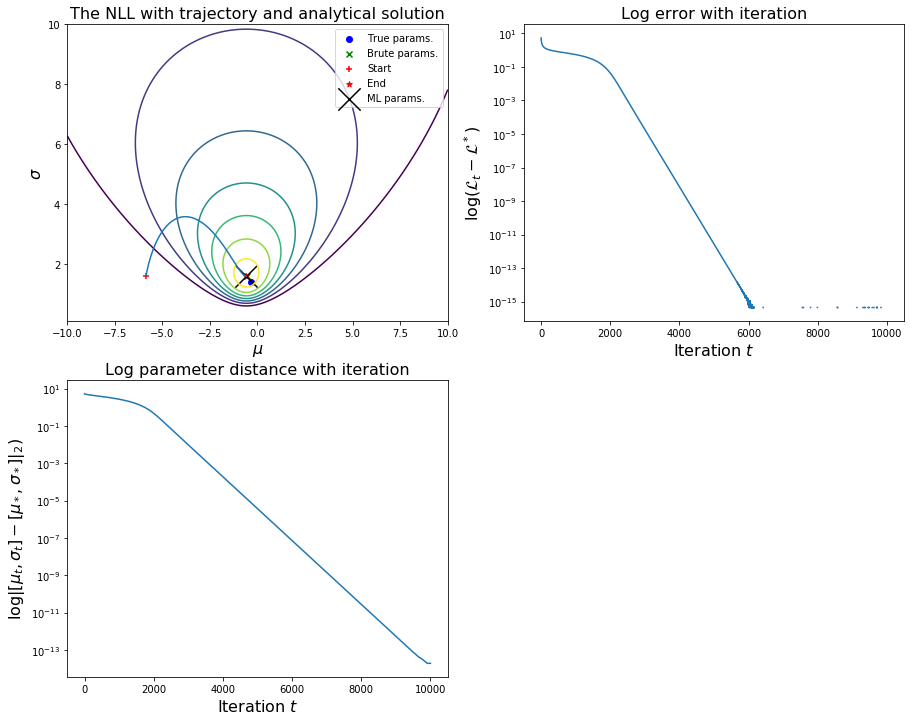

In [24]:
nllML = nll(data, muML, sigmaML)

# Plotting
plt.figure(3, figsize=(15,12))

# Top left figure: trajectory
plt.subplot(2,2,1)
plt.contour(X,Y,np.exp(-nlls.T))
plt.scatter(mean_true, np.sqrt(var_true), color='b', marker='o')
plt.scatter(mean_brute, std_brute, color='g', marker='x')

# Plot trajectory ends
plt.scatter(mu0, sigma0, color='r', marker='+')
plt.scatter(muend, sigmaend, color='r', marker='*')
plt.scatter(muML, sigmaML, color='k', marker='x', s=500)
plt.legend(['True params.', 'Brute params.', 'Start', 'End', 'ML params.'])

plt.plot(mus, sigmas)

# Labelling
plt.xlabel('$\mu$', fontsize=16)
plt.ylabel('$\sigma$', fontsize=16)
plt.title('The NLL with trajectory and analytical solution', fontsize=16)

plt.subplot(2,2,2)
# Top right figure: difference in loss from optimum
plt.semilogy(losses - nllML)
plt.xlabel('Iteration $t$', fontsize=16)
plt.ylabel('$\log(\mathcal{L}_t - \mathcal{L}^*)$', fontsize=16)
plt.title('Log error with iteration', fontsize=16)

plt.subplot(2,2,3)
# Bottom left figure: L2 distance between trajectory parameters and ML solution
parameter_distance = np.sqrt((mus - muML)**2 + (sigmas - sigmaML)**2)
plt.semilogy(parameter_distance)
plt.xlabel('Iteration $t$', fontsize=16)
plt.ylabel('$\log \| [\mu_t,\sigma_t] - [\mu_*, \sigma_*] \|_2)$', fontsize=16)
plt.title('Log parameter distance with iteration', fontsize=16)

end_dist = np.sqrt((mean_brute - muML)**2 + (std_brute - sigmaML)**2)
print("True parameters vs. brute force parameters distance: {}".format(end_dist))

## Part 2
You have written a gradient descent optimizer to numerically compute the optimum of the Gaussian likelihood. You also computed the ML estimates of the parameters and compared the two. Now you are going to write a gradient descent optimizer to optimize a 1D logistic regressor.

For the next few boxes, read and run the code until the next **TODO**

### Logistic regression
In logistic regression, we are performing a classification task. Given an input $x_i \in \mathbb{R}$, there is an associated 'label' $y_i$ which can take on values in $\{0,1\}$. The two possible outcomes refer to two 'classes'. The model used is a Bernoulli distribution, 

$$P(y | x, w, b) = \text{Bernoulli}(y | wx + b) = \sigma(wx+b)^y (1 - \sigma(wx+b))^{1-y},$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is a sigmoid function. It looks like

Text(0,0.5,'$y = \\sigma(x)$')

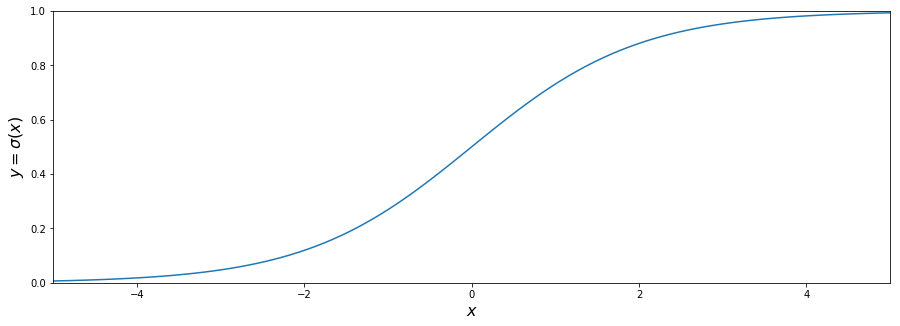

In [25]:
x = np.linspace(-5,5,num=100)
y = 1 / (1 + np.exp(-x))

plt.figure(4, figsize=(15,5))
plt.plot(x,y)
plt.xlim(-5,5)
plt.ylim(0,1)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y = \sigma(x)$', fontsize=16)

The model has two parameters $w,b$, which are both real numbers. The *slope* $w$ controls the gradient of the sigmoid and the *bias* $b$ controls the position of the sigmoid. See examples below

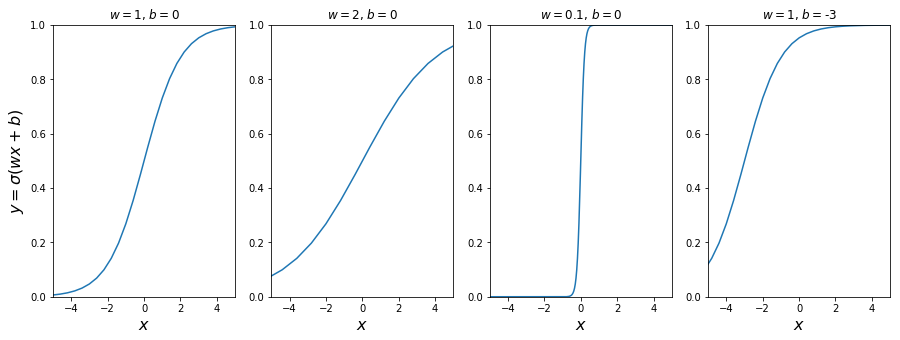

In [26]:
x = np.linspace(-100,100,num=500)
y = 1 / (1 + np.exp(-x))

plt.figure(5, figsize=(15,5))
ws = [1,2,0.1,1]
bs = [0,0,0,-3]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(ws[i]*x+bs[i],y)
    plt.xlim(-5,5)
    plt.ylim(0,1)
    plt.xlabel('$x$', fontsize=16)
    if i == 0:
        plt.ylabel('$y = \sigma(wx+b)$', fontsize=16)
    plt.title('$w=${}, $b=${}'.format(ws[i], bs[i]))

The averaged negative log-likelihood of this model is then

\begin{align}\mathcal{L}(w,b) &= -\frac{1}{N} \sum_{i=1}^N \log P(y_i | x_i, w, b) \\
&= -\frac{1}{N} \sum_{i=1}^N \log (\sigma(wx_i+b))^{y_i} (1 - \sigma(wx_i+b))^{1-y_i} \\
&= -\frac{1}{N} \sum_{i=1}^N y_i \log (\sigma(wx_i+b)) + (1-y_i)\log(1 - \sigma(wx_i+b)) \\
\end{align}

You are given data $\mathcal{D}=\{(x_i, y_i)\}$, generated from a distribution as shown

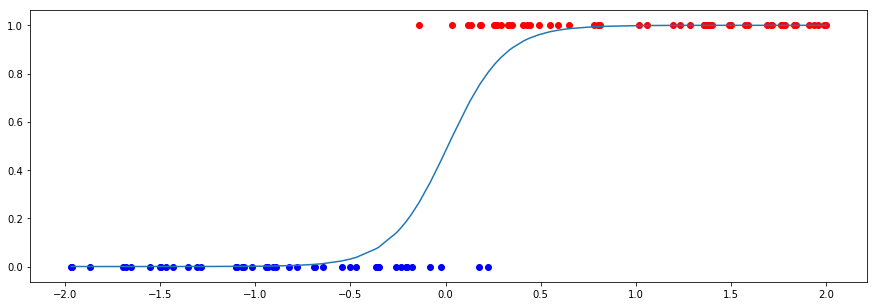

In [27]:
N = 100
wtrue = 5+2*np.random.rand()
btrue = np.random.randn()

xdata = 4*(np.random.rand(N)-0.5)
xdata = np.sort(xdata)


ytrue = 1 / (1 + np.exp(-(wtrue*xdata + btrue)))
ydata = (np.random.rand(N) + ytrue) > 1

plt.figure(6, figsize=(15,5))
plt.plot(xdata,ytrue)
plt.scatter(xdata[ydata==0], ydata[ydata==0], color='b')
plt.scatter(xdata[ydata==1], ydata[ydata==1], color='r')

**TODO** Write the averaged negative log-likelihood function in terms of $w$ and $b$. Note that computing $\log (\sigma (x))$ is actually unstable, and so we have included a stable `log_sigmoid` function for you. Note also that $\log (1 - \sigma (x)) = \log(\sigma(-x))$.

**`for` loops are not allowed!**

Hint: It helps to write the averaged NLL in two steps:

\begin{align}
    z_i &= wx_i + b \\
    \mathcal{L}(w,b) &= -\frac{1}{N} \sum y_i \log \sigma (z_i) + (1 - y_i) \log (1-\sigma (z_i))
\end{align}

In [28]:
def log_sigmoid(x):
    return -np.log(1+np.exp(-x))

def nll(xdata, ydata, w, b):
    z = xdata*w + b
    a = ydata*log_sigmoid(z)+(1-ydata)*(log_sigmoid(-z))
    return -np.mean(a)

Text(0.5,1,'The NLL')

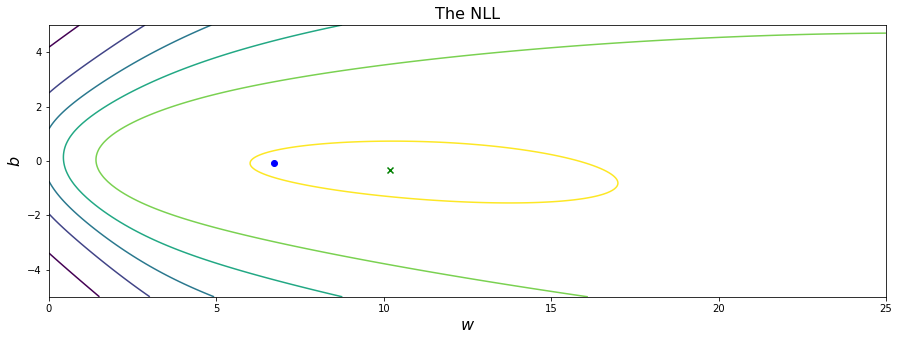

In [29]:
# Domain of the parameters space
wspace = np.linspace(0, 25, num=200)
bspace = np.linspace(-5, 5, num=200)

# Compute the value of the nll at each parameter value: note this is an inefficient method
nlls = []
for w in wspace:
    for b in bspace:
        nlls.append(nll(xdata, ydata, w, b))
nlls = np.asarray(nlls).reshape(200,200)

NLL_min = np.amin(nlls)
ind = np.unravel_index(np.argmin(nlls, axis=None), nlls.shape)
w_brute = wspace[ind[0]]
b_brute = bspace[ind[1]]

plt.figure(7, figsize=(15,5))
X, Y = np.meshgrid(wspace, bspace)
plt.contour(X,Y,np.exp(-nlls.T))

# Plot the true parameters with a blue circle
plt.scatter(wtrue, btrue, color='b', marker='o')

# Plot the brute force ML parameters with a green cross
plt.scatter(w_brute, b_brute, color='g', marker='x')

plt.xlabel('$w$', fontsize=16)
plt.ylabel('$b$', fontsize=16)
plt.title('The NLL', fontsize=16)

### Gradient descent on the NLL
Now we are going to compute the maximum likelihood (ML) slope and bias through numerical optimization of the averaged negative log-likelihood of the parameters given the data. Don't worry, **we have written down the gradient expressions for you**. At iteration $t$ you will update the parameters $w_t$ or $b_t$ (jointly referred to as $\theta_t$) according to the equation

$$\theta_{t+1} \gets \theta_t - \lambda \left . \frac{\partial \mathcal{L}}{\partial \theta} \right |_{\theta=\theta_t}$$

At iteration $t$ we denote the loss $\mathcal{L}_t = \mathcal{L}(w_t, b_t)$. The optimal loss is $\mathcal{L}^* = \mathcal{L}(w^*, b^*)$.

**TODO** Accustom yourself with the code below, then fill in the missing parts. You need to fill in:
- `sigmoid`: takes in a scalar or array of numbers `x`, returns $\sigma(x) = 1/(1+e^{-x})$
- `dLdw(xdata, ydata, w, b)`: takes in an array `xdata` of $N$ data points $\{x_i\}$ with an array of labels `ydata` for $\{y_i\}$, a slope `w`, and a scalar `b`. It should return a scalar for the gradient of the averaged negative log-likelihood wrt the slope i.e. 
$$\texttt{dLdw(xdata,ydata,w,b)} = -\frac{\partial}{\partial w} \left ( \mathcal{L}(w,b) \right) = -\frac{1}{N} \sum_{i=1}^N x_i(y_i - \sigma(wx_i + b))$$
- `dLdb(xdata, ydata, w, b)`: takes in an array `xdata` of $N$ data points $\{x_i\}$ with an array of labels `ydata` for $\{y_i\}$, a slope `w`, and a scalar `b`. It should return a scalar for the gradient of the averaged negative log-likelihood wrt the bias i.e. 
$$\texttt{dLdb(xdata,ydata,w,b)} = -\frac{\partial}{\partial b} \left ( \mathcal{L}(w,b) \right) = -\frac{1}{N} \sum_{i=1}^N (y_i - \sigma(wx_i + b))$$

**It would be a good exercise for you to work out these gradients from the NLL for yourself, but you do not need to hand them in.**

Note you may need to play around with the learning rate and number of iteration to get this to converge. If it gets stuck for a long time, just resample the data.

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dLdw(xdata, ydata, w, b):
    return -np.mean(xdata*(ydata - sigmoid(w*xdata + b)))

def dLdb(xdata, ydata, w, b):
    return -np.mean(ydata - sigmoid(w*xdata + b))

Final NLL: 0.12030049669332131


Text(0.5,1,'The NLL with trajectory')

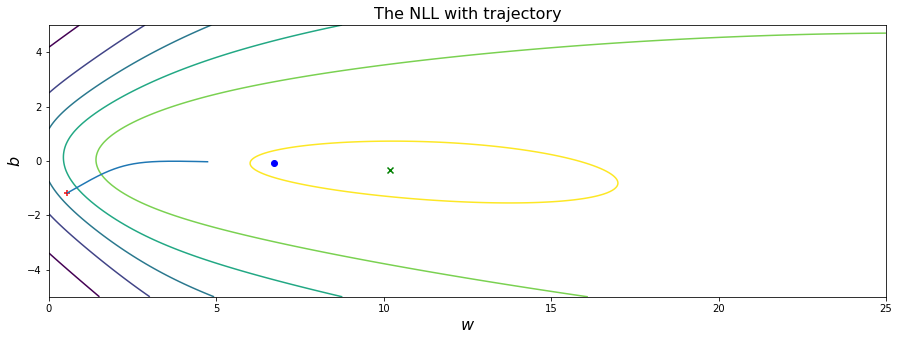

In [31]:
# Randomly initialize the mean and variance
w0 = 25*np.random.rand()
b0 = 10*(np.random.rand()-0.5)

w = w0
b = b0

# These lists will store the trajectories of the parameters and loss
ws = [w0,]
bs = [b0,]
losses = []

# Optimization meta-parameters
learning_rate = 1e-1
n_iter = 1000

# The optimization loop
for t in range(n_iter):
    loss = nll(xdata, ydata, w, b)
    w_new = update_parameter(learning_rate, w, dLdw(xdata, ydata, w, b))
    b_new = update_parameter(learning_rate, b, dLdb(xdata, ydata, w, b))
    
    w = w_new
    b = b_new
    
    ws.append(w)
    bs.append(b)
    losses.append(loss)

    
ws = np.asarray(ws)
bs = np.asarray(bs)
losses = np.asarray(losses)

final_nll = losses[-1]
wend = ws[-1]
bend = bs[-1]
print("Final NLL: {}".format(final_nll))

###############################################################
# Plotting
plt.figure(8, figsize=(15,5))
# Left figure: trajectory of the ML mean and std over time
plt.contour(X,Y,np.exp(-nlls.T))

# Plot the true parameters with a blue circle
plt.scatter(wtrue, btrue, color='b', marker='o')

# Plot the brute force ML parameters with a green cross
plt.scatter(w_brute, b_brute, color='g', marker='x')

# Plot trajectory
plt.plot(ws, bs)
plt.scatter(ws[0], bs[0], color='r', marker='+')

# Labelling
plt.xlabel('$w$', fontsize=16)
plt.ylabel('$b$', fontsize=16)
plt.title('The NLL with trajectory', fontsize=16)

This last bit of code compares the result of your gradient descent algorithm with the output of a more advanced optimizer from the `scipy.optimize` library. Have a look at the library if you are interested. You should notice that gradient descent has highly variable rates of convergence to the optimum. Can you think of intuitive reasons why? 

### Answer: 

#### I suspect the convergence rate to the optimum is highly dependent on the function that we are trying to optimize

True parameters vs. brute force parameters distance: 0.04762397679584066


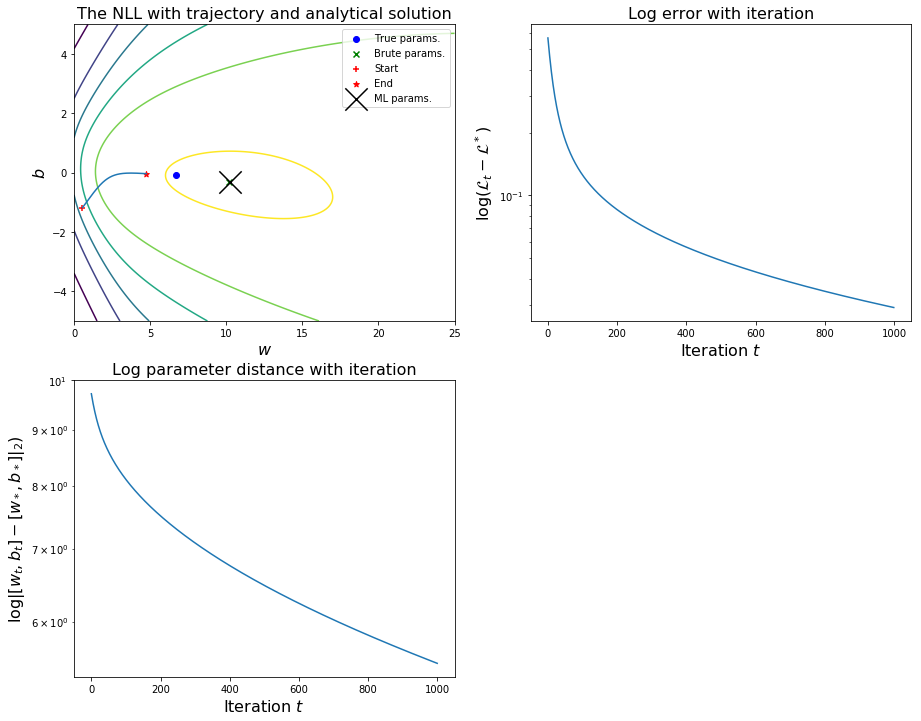

In [32]:
fun = lambda x: nll(xdata, ydata, x[0], x[1])
res = minimize(fun, [w0,b0])
wML = res['x'][0]
bML = res['x'][1]

nllML = nll(xdata, ydata, wML, bML)

# Plotting
plt.figure(9, figsize=(15,12))

# Top left figure: trajectory
plt.subplot(2,2,1)
plt.contour(X,Y,np.exp(-nlls.T))
plt.scatter(wtrue, btrue, color='b', marker='o')
plt.scatter(w_brute, b_brute, color='g', marker='x')

# Plot trajectory ends
plt.scatter(w0, b0, color='r', marker='+')
plt.scatter(wend, bend, color='r', marker='*')
plt.scatter(wML, bML, color='k', marker='x', s=500)
plt.legend(['True params.', 'Brute params.', 'Start', 'End', 'ML params.'])

plt.plot(ws, bs)

# Labelling
plt.xlabel('$w$', fontsize=16)
plt.ylabel('$b$', fontsize=16)
plt.title('The NLL with trajectory and analytical solution', fontsize=16)

plt.subplot(2,2,2)
# Top right figure: difference in loss from optimum
plt.semilogy(losses - nllML)
plt.xlabel('Iteration $t$', fontsize=16)
plt.ylabel('$\log(\mathcal{L}_t - \mathcal{L}^*)$', fontsize=16)
plt.title('Log error with iteration', fontsize=16)

plt.subplot(2,2,3)
# Bottom left figure: L2 distance between trajectory parameters and ML solution
parameter_distance = np.sqrt((ws - wML)**2 + (bs - bML)**2)
plt.semilogy(parameter_distance)
plt.xlabel('Iteration $t$', fontsize=16)
plt.ylabel('$\log \| [w_t,b_t] - [w_*, b_*] \|_2)$', fontsize=16)
plt.title('Log parameter distance with iteration', fontsize=16)

end_dist = np.sqrt((w_brute - wML)**2 + (b_brute - bML)**2)
print("True parameters vs. brute force parameters distance: {}".format(end_dist))
